## Calcolo del calore specifico di una fase minerale in condizioni di alta pressione

Come fatto presente nelle slide, non è difficile per via calorimetrica misurare il calore specifico di una sostanza a pressione ambiente. Molto più difficile e inaccurato è fare quelle misure in alta pressione. Per cui, la via che si segue nelle modellizzazioni termodinamiche, per cui occorre calcolare l'energia libera *G* in condizioni P/T generiche, è sfruttare il *Cp* per calcolare come varia *G* a *P* ambiente fino alla temperatura voluta *T* (cammino 2 nella figura sottostante), e poi calcolare il contributo barico a *G* sfruttando il termine *VdP* (cammino 3), il che implica usare l'equazione di stato alla temperatura *T*

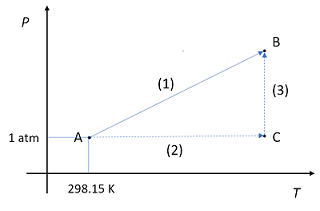

Una volta che si sia ottenuto il modo \[per questa via (2+3)\] di calcolare *G* ad ogni condizione P/T, possiamo però anche calcolarci il calore specifico e la sua dipendenza dalla temperatura in condizioni diverse da quelle della pressione ambiente.

Per fare questo, sfruttiamo la definizione di entropia; a pressione costante:

<br>

$$dS = \frac{(\delta Q)_P}{T} = \frac{C_P(T)}{T}dT \ \rightarrow \ C_P(T)=T\left(\frac{\partial S}{\partial T}\right)_P$$

Ma sappiamo anche che 

$$S =-\left(\frac{\partial G}{\partial T}\right)_P \ \rightarrow \ C_P(T)=-T\left(\frac{\partial^2G}{\partial T^2}\right)_P$$

In sostanza, calcoliamo il calore specifico a qualunque pressione e temperatura, dalla derivata seconda della $G(T,P)$ rispetto alla temperatura, a pressione costante.

Ciò è proprio quello che faremo in questo notebook, per il piropo, sfruttando il programma *gibbs_tp* e il suo metodo *g_tp* della classe *mineral* per calcolare *G* a qualunque valore di *T* e *P* (a partire dal calore specifico a pressione ambiente e l'equazione di stato).

Come di consueto, carichiamo e lanciamo il programma gibb_tp.py

In [1]:
%matplotlib inline
%run gibbs_tp.py

Controlliamo la presenza dei dati termodinamici su piropo:

In [2]:
py.info()

Mineral: pyrope

K0: 173.70 GPa, Kp: 4.00, dK0/dT: -0.0261 GPa/K, V0: 11.3180 J/bar
G0: -5934105.00 J/mol, S0: 266.30 J/mol K

Cp coefficients and powers:
+6.3350e+02  +0.0
-5.1961e+06  -2.0
-4.3152e+03  -0.5

Alpha coefficients and powers:
+4.3600e-05  +0.0
-4.3600e-04  -0.5


A pressione ambiente, possiamo calcolare il calore specifico a qualunque temperatura sfruttando il metodo *cp_t*. Per esempio, a T=300 K, abbiamo:

In [3]:
py.cp_t(300).round(3)

326.627

Adesso scriviamo una funzione (*cp_p*) che ci consenta di calcolare il $C_P$ a partire dalla derivata seconda della $G$ rispetto a $T$ come descritto sopra. Il codice è riportato nella cella seguente.

L'idea consiste in:

- costruiamo una lista di 8 valori di temperatura centrata sul valore di $T$ per il quale vogliamo ottenere il $C_P$, a partire da $T_{min}=T-5$ fino a $T_{max}=T+5$
- calcoliamoci i valori di $G$ per ogni temperatura nella lista e alla pressione $P$ voluta
- facciamo un fit polinomiale del quarto ordine dei valori di $G(T)$
- sulla polinomiale $G(T)$ ottenuta, facciamo la derivata seconda e, di questa derivata, calcoliamo il valore alla temperatura voluta
- moltiplichiamo il valore della derivata ottenuta per $-T$

In [4]:
def cp_p(t,p):
    dt=5.
    deg=4
    tmin=t-dt
    tmax=t+dt
    t_list=np.linspace(tmin,tmax,8)
    g_list=np.array([])
    for it in t_list:
        ig=py.g_tp(it,p)
        g_list=np.append(g_list,ig)
        
    reg=np.polyfit(t_list,g_list,deg) # fit polinomiale
    der2=np.polyder(reg,2)            # derivata seconda del fit
    cpp=-1*t*np.polyval(der2,t)       # valore della derivata alla 
                                      # temperatura moltiplicata per -t
    return cpp

Proviamo la funzione a T=300 K e P ambiente (0 GPa)

In [26]:
cp_p(300,0).round(3)

326.628

Come si vede, il valore ottenuto è molto vicino a quello calcolato sopra, usando *cp_t*. 

Ma noi siamo *scettici*, e vogliamo controllare il risultato di *cp_p* su un intervallo più esteso di temperatura, a *P*=0, confrontandolo con i risultati di *cp_t* nello stesso intervallo di temperatura... Quindi scriviamo il codice che segue e lo eseguiamo:


Errore medio sul Cp: 0.00011


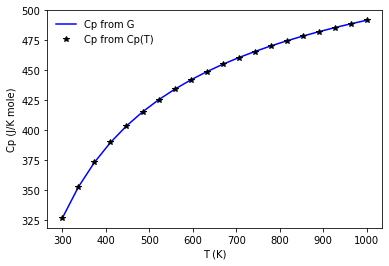

In [5]:
t_list=np.linspace(300,1000,20)
cp_new_list=np.array([])
cp_old_list=np.array([])
for it in t_list:
    icpn=cp_p(it,0)
    icpo=py.cp_t(it)
    cp_new_list=np.append(cp_new_list,icpn)
    cp_old_list=np.append(cp_old_list,icpo)
    
dcp=(cp_old_list-cp_new_list)**2
error=np.sqrt(np.sum(dcp)/len(cp_new_list))
print("\nErrore medio sul Cp: %7.5f" % error)    
    
plt.figure()
plt.plot(t_list,cp_new_list,"b-", label="Cp from G")
plt.plot(t_list,cp_old_list,"k*", label="Cp from Cp(T)")
plt.xlabel("T (K)")
plt.ylabel("Cp (J/K mole)")
plt.legend(frameon=False)
plt.show()

L'errore medio sul $C_P$ (in J/K mole) è molto basso (una unità sulla 4^ decimale). La curva in blu mostra i dati calcolati con la nuova funzione *cp_p*; gli asterischi in nero mostrano il $C_P$ calcolato con la vecchia funzione *cp_t*: l'accordo tra i due metodi è eccellente: vuol dire che non abbiamo fatto errori sia 

- nella teoria, 
- nel modo con cui calcoliamo le derivate (8 punti in temperatura in un certo intervallo, interpolati con una polinomiale del quarto ordine... sono tutte scelte di *parametri numerici* fatte *a buon senso*, ma non è scontato che siano adeguate al caso, perciò è necessario fare i dovuti test e controlli incrociati), 
- nel codice python che è stato scritto. 

Adesso che ci *fidiamo* della nuova funzione, scriviamo il codice di un'altra funzione che la sfrutti per confrontare il $C_P$ in un certo intervallo di temperature, a pressioni crescenti:

In [60]:
def cp_p_serie(pmin,pmax,npp):
    t_list=np.linspace(300,1000,20)
    p_list=np.linspace(pmin,pmax,npp)
    
    plt.figure()
    for ip in p_list:
        cp_list=np.array([])
        for it in t_list:
            icpt=cp_p(it,ip)
            cp_list=np.append(cp_list,icpt)
            
        lbl="P: "+str(ip)+" GPa"    
        plt.plot(t_list,cp_list,label=lbl)
        
    plt.xlabel("T (K)")
    plt.ylabel("Cp (J/K mole)")
    plt.legend(frameon=False)
    plt.show()

Cacoliamo dunque, con questa funzione, l'andamento di $C_P(T)$ alle pressioni di 0, 15 e 30 GPa:

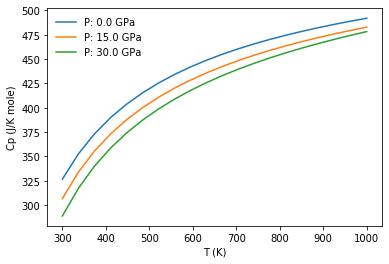

In [63]:
cp_p_serie(0,30,3)

Otteniamo curve quasi *parallele* che si spostano a valori via via più bassi al salire della pressione. Confrontare il risultato *numerico* ottenuto con le predizioni della *teoria* riportate a pagina 19 delle dispense (formula 1.49).